# Installation, data loading, and imports

In [1]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
import numpy as np
from typing import List
import tensorflow as tf
import pisces.models as pm
from importlib import reload
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType
from importlib import reload
from scipy.special import softmax

import os
from pathlib import Path

CWD = Path(os.getcwd())
# NB! these are different from preprocess_data.ipynb
save_path = CWD.joinpath("fine_tuning")

hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)



In [3]:
MAX_PSG_EPOCHS = 1024


smartmap_input_shape = (-1, 1024, 4)
lr_input_shape = (-1, 2048, 1)
label_shape = (-1, 1024, 1)

In [4]:
epochs = 15
break_up_line = "=" * 20

# TF Model Definitions

In [5]:
from dataclasses import dataclass
from sklearn.calibration import expit
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom loss function that takes weights into account
def weighted_binary_crossentropy(y_true, y_pred, sample_weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)[..., None]
    weighted_bce = bce * sample_weight
    return tf.reduce_mean(weighted_bce)

def make_mo_model():
    sampling_hz = 32 # Hz
    input_features = ['accelerometer']
    model_input = ModelInputSpectrogram(input_features, sampling_hz)
    output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
    mo = pm.MOResUNetPretrained(data_processor=None, sampling_hz=sampling_hz, lazy_model_loading=False)

    return mo

# Function to build the CNN-based mixture model
def build_smartmap_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)  # Input shape (1024, 4)

    # First 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='linear')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # # Second 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, padding='same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # x = tf.keras.layers.Dropout(0.1)(x)

    # Output Layer: Binary classification (Wake or Sleep)
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation='linear')(x)

    # The output shape will be (1024, 1) per example, representing the probability of Sleep at each timestep
    return tf.keras.Model(inputs=inputs, outputs=x)

def cnn_pred_proba(cnn, data):
    return expit(
        cnn.predict(
            data.reshape(1, 1024, 4)
        )).reshape(-1,)

def naive_pred_proba(data):
    return 1 - softmax(data, axis=-1)[:, 0]

In [6]:

# Custom model class
class WeightedModel(tf.keras.Model):
    def __init__(self, original_model):
        super(WeightedModel, self).__init__()
        self.original_model = original_model

    def call(self, inputs):
        x = inputs
        return self.original_model(x)

    def train_step(self, data):
        x, y_true, sample_weight = data

        with tf.GradientTape() as tape:
            y_pred = self.original_model(x, training=True)
            loss = weighted_binary_crossentropy(y_true, y_pred, sample_weight)

        # Compute gradients and update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        return {"loss": loss}

# Original model
def build_lr_cnn(kernel_size: int = 21):
    input_layer = layers.Input(shape=(2048, 1), name="activity_input")
    x = layers.Conv1D(filters=1, kernel_size=kernel_size, strides=2, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model

def lr_cnn_pred_proba(lr_cnn, data: tf.Tensor):
    return expit(
        lr_cnn.predict(
            tf.reshape(data, (1, 2048, 1))
        )).reshape(-1,)
# Create original and weighted models
original_model = build_lr_cnn()
weighted_model = WeightedModel(original_model)

# Compile the model with an optimizer
weighted_model.compile(optimizer='adam', metrics=['auc'])

# Generate dummy data
N_SAMPLES = 5
x_data = tf.random.normal((N_SAMPLES, 2048, 1), dtype=tf.float32)
y_data = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)
sample_weights = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)

# Train the model using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, sample_weights))
dataset = dataset.batch(1)

# Fit the model
weighted_model.fit(dataset, epochs=2, validation_data=None)


Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0185
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0192


# Weighting and analysis functions

In [7]:
import json
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import auc, roc_curve
from sklearn.utils import class_weight
import numpy as np
WASA_SLEEP_ACCURACY = 0.97
WASA_SLEEP_PERCENT = int(100 * WASA_SLEEP_ACCURACY)
WASA_COLUMN = f"WASA{int(WASA_SLEEP_ACCURACY*100)}"
AUROC_COLUMN = "AUROC"
ACCURACY_COLUMN = "WeightedAccuracy"

def compute_sample_weights(labels: np.ndarray, verbose: bool = False) -> np.ndarray:
    mask_weights = labels >= 0
    if verbose:
        print(f"Scored % of {labels.size} epochs:\n{100 * (np.sum(mask_weights) / mask_weights.size):.2f} ({np.sum(mask_weights)} / {mask_weights.size})")

    class_weight_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=labels[mask_weights].flatten()
    )
    class_weights = {0: class_weight_array[0], 1: class_weight_array[1]}
    if verbose:
        print("Class weights:\n", json.dumps(class_weights, indent=2)) # pretty print
    class_weights |= {-1: 0.0}

    def weight_fn(x):
        return class_weights[x]
    
    wfv = np.vectorize(weight_fn)
    sample_weights = wfv(labels)

    return sample_weights

def compute_mae_for_sleep_time(y_true, y_pred):
    # Reshape to simplify processing (remove the singleton dimensions)
    y_true = tf.cast(tf.squeeze(y_true), tf.float32)
    y_pred = tf.cast(tf.squeeze(y_pred), tf.float32)
    
    # Mask out the indices where y_true == -1
    true_mask = tf.cast(tf.equal(y_true, 1.0), tf.float32)
    pred_mask = tf.cast(tf.equal(y_pred, 1.0), tf.float32)

    masked_y_true = tf.boolean_mask(y_true, true_mask)
    masked_y_pred = tf.boolean_mask(y_pred, pred_mask)
    
    # # Ensure masked tensors are float32 for comparison and calculation
    # masked_y_true = tf.cast(masked_y_true, tf.float32)
    # masked_y_pred = tf.cast(masked_y_pred, tf.float32)
    
    # Calculate total sleep time (sum of values where label is 1)
    SECONDS_PER_PSG = 30
    SECONDS_PER_MINUTE = 60
    SCALAR = SECONDS_PER_PSG / SECONDS_PER_MINUTE
    
    true_sleep_time = tf.reduce_sum(masked_y_true)
    pred_sleep_time = tf.reduce_sum(masked_y_pred)
    
    # Compute Mean Absolute Error (MAE) for total sleep time
    # mae = tf.abs(SCALAR * (true_sleep_time - pred_sleep_time))
    mae = SCALAR * (true_sleep_time - pred_sleep_time)
    return mae



def masked_weighted_accuracy(y_true, y_pred, sample_weight):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sample_weight = tf.cast(sample_weight, tf.float32)
    correct = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    weighted_accuracy = tf.reduce_sum(correct * sample_weight) / tf.reduce_sum(sample_weight)

    return weighted_accuracy.numpy()



def auroc_balaccuracy_wasa(split_name, binary_pred_proba, test_sample_weights, test_labels_masked, sleep_accuracy):

    flat_test_labels = test_labels_masked.reshape(-1,)
    flat_weights = test_sample_weights.reshape(-1,)

    # # compute AUROC
    fpr, tpr, thresholds = roc_curve(flat_test_labels, binary_pred_proba, sample_weight=flat_weights)
    roc_auc = auc(fpr, tpr)

    # # compute WASA
    wasa_threshold = thresholds[np.sum(tpr <= sleep_accuracy)]
    y_guess = binary_pred_proba > wasa_threshold
    guess_right = y_guess == flat_test_labels
    y_wake = (flat_test_labels == 0) & (flat_weights > 0)
    n_wake = np.sum(y_wake)
    n_wake_right = np.sum(y_wake & guess_right)
    wake_accuracy = n_wake_right / n_wake

    # weighted_accuracy = masked_weighted_accuracy(
    #     flat_test_labels,
    #     y_guess,
    #     flat_weights)
    mae_tst = compute_mae_for_sleep_time(flat_test_labels, y_guess).numpy()

    print("=" * 20)
    print(f"Fold {split_name}")
    print(f"\tROC AUC: {roc_auc}")
    # print(f"\tWEIGHTED accuracy @ ≧{WASA_SLEEP_PERCENT}% sleep: {mae_tst}")
    print(f"\tMAE Total Sleep Time: {mae_tst}")
    print(f"\t{WASA_COLUMN}: {wake_accuracy} ({n_wake_right} / {n_wake} || threshold: {wasa_threshold})")
    print("=" * 20)
    return roc_auc, mae_tst, wake_accuracy


@dataclass
class PreparedData:
    activity: tf.Tensor 
    spectrogram: tf.Tensor 
    mo_predictions: tf.Tensor 
    true_labels: tf.Tensor 
    sample_weights: tf.Tensor 


def prepare_data(preprocessed_data: dict):
    mo = make_mo_model()
    keys = list(preprocessed_data.keys())
    xyz_specgram_input = np.array([
        preprocessed_data[k]['spectrogram']
        for k in keys
    ])
    xyz_average = xyz_specgram_input #np.mean(xyz_specgram_input, axis=-1)

    specgram_input = np.zeros((*xyz_average.shape, 2))
    # embed x,y,z into 2 channels
    # one is reflected along the frequency axis
    specgram_input[..., 0] = xyz_average
    specgram_input[..., 1] = xyz_average[..., ::-1]
    
    mo_predictions = mo.predict_logits(specgram_input)

    full_labels = np.array([
        preprocessed_data[k]['psg'][:, 1]
        for k in keys
    ])
    labels = np.where(full_labels > 0, 1, full_labels)

    # in original setup, specgrams were average of x,y,z
    # specgrams = np.mean(xyz_specgram_input, axis=-1)
    specgrams = xyz_specgram_input

    activity = np.array([
        preprocessed_data[k]['activity'][:, 1]
        for k in keys
    ])
    weights = np.array([
        compute_sample_weights(labels[i])
        for i in range(labels.shape[0])
    ])
    return PreparedData(
        activity=tf.convert_to_tensor(activity, dtype=tf.float32),
        spectrogram=tf.convert_to_tensor(specgrams, dtype=tf.float32),
        mo_predictions=tf.convert_to_tensor(mo_predictions, dtype=tf.float32),
        true_labels=tf.convert_to_tensor(labels, dtype=tf.float32),
        sample_weights=tf.convert_to_tensor(weights, dtype=tf.float32)
    )


# Plotting functions

In [8]:
from matplotlib import rcParams
import seaborn as sns

color_palette = sns.color_palette("colorblind")

def tri_plot_metrics(evaluations_df: List[tuple], save_dir: Path | None = None, PLOT_TITLE: str = "Metrics", axs: List[plt.Axes] | None = None, axs_set_name: str | None = None, filename: str | None = None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig = axs[0].figure

    metrics = {
        'sw_accuracy': evaluations_df[ACCURACY_COLUMN],
        'auc': evaluations_df[WASA_COLUMN],
        'wasa': evaluations_df[AUROC_COLUMN]
    }

    rcParams['font.family'] = 'Helvetica'
    rcParams['font.size'] = 12  # Set a global font size

    metrics_dimensions = {'sw_accuracy': f'B.Acc{WASA_SLEEP_PERCENT}', 'auc': 'AUC', 'wasa': WASA_COLUMN}
    metric_colors = {'sw_accuracy': color_palette[4], 'auc': color_palette[1], 'wasa': color_palette[2]}

    if axs_set_name is not None:
        axs[0].set_title(axs_set_name)

    for metric, ax in zip(metrics_dimensions.keys(), axs):
        sns.histplot(
            metrics[metric],
            bins=20,
            stat='percent',
            kde=True,
            color=metric_colors[metric],
            ax=ax)
        ax.axvline(np.mean(metrics[metric]), color='red', linestyle='dashed', linewidth=2, label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.5f}")
        # ax.set_title(metrics_dimensions[metric])
        ax.set_xlabel(metrics_dimensions[metric])
        if metric != 'sw_accuracy':
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 20)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Customize the remaining spines (left and bottom)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        ax.set_ylabel('% Density')
        ax.legend()

    fig.suptitle(PLOT_TITLE,
                 fontsize=20)
    fig.tight_layout()
    if save_dir is not None:
        if filename is None:
            filename = 'tri_plot_metrics.png'
        fig.savefig(save_dir.joinpath(filename), dpi=600, bbox_inches='tight')

In [9]:
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

def add_spectrogram(ax, specgram):
    ax.imshow(specgram.T, aspect='auto', origin='lower', vmax=20, vmin=-20)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Specgram')
    ax.set_ylabel('Frequency')

def add_smartmap_inputs(ax, input_data):
    input_t = input_data.T
    INPUT_EPOCHS = input_data.shape[0]
    ax.stackplot(range(INPUT_EPOCHS), softmax(input_t, axis=0))
    ax.set_xlim(0, INPUT_EPOCHS)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'SmartMap Training Input')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_lr_inputs(ax, input_data):
    cnn_input_width = input_data.shape[0]
    ax.plot(range(cnn_input_width), input_data)
    ax.set_xlim(0, cnn_input_width)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Actigraphy')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_hypnogram(ax, binary_pred_proba, true_labels, naive_prediction, model_type):
    binary_label = 'SmartMap Prediction' if model_type == 'smartmap' else 'LR Prediction'
    ax.plot(binary_pred_proba, label=binary_label)
    if naive_prediction is not None:
        ax.plot(naive_prediction, label='Naive: 1 - P(wake)')

    sample_weight = compute_sample_weights(true_labels)
    masked_true_labels = np.where(sample_weight, true_labels, -1)

    ax.plot(masked_true_labels, label='Actual', linestyle='--')
    ax.set_xlim(0, len(binary_pred_proba))
    ax.set_ylabel('Probability of Sleep')
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Hypnogram')
    ax.legend()

    return masked_true_labels, sample_weight


def add_roc(ax, binary_pred_proba, true_labels, sample_weight, naive_prediction: np.ndarray | None = None):
    masked_true_labels = np.where(sample_weight, true_labels, 0)
    fpr, tpr, thresholds = roc_curve(masked_true_labels, binary_pred_proba, sample_weight=sample_weight)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    roc_auc_naive = None
    if naive_prediction is not None:
        # Plot the ROC curve from naive_prediction
        fpr_naive, tpr_naive, _ = roc_curve(masked_true_labels, naive_prediction, sample_weight=sample_weight)
        roc_auc_naive = auc(fpr_naive, tpr_naive)
        ax.plot(fpr_naive, tpr_naive, color='green', lw=2, label=f'Naive ROC curve (area = {roc_auc_naive:.2f})')
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Wake Predicted as Sleep')
    ax.set_ylabel('Sleep Predicted as Sleep')
    ax.legend(loc="lower right")

    return roc_auc, roc_auc_naive

from typing import List
def ranked_debug_plots(df, eval_data, true_labels, predictors, evaluator, specgrams, filename_suffix: str, model_type: str, split_names: List[str] = None):
    indices = df.sort_values(ACCURACY_COLUMN, ascending=False).index
    aurocs = []
    

    for rank, idx in enumerate(indices):
        if idx >= len(eval_data):
            continue
        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        fig.subplots_adjust(hspace=0, left=0)
        
        # Plot the specgram
        _ = add_spectrogram(axs[0], specgrams[idx])
        
        # Plot the CNN training input as a stacked area plot
        if model_type == 'smartmap':
            add_smartmap_inputs(axs[1], eval_data[idx].squeeze(), )
        elif model_type == 'lr':
            add_lr_inputs( axs[1], eval_data[idx].squeeze(),)
        
        # Plot the final output along with the correct value

        binary_pred_proba = evaluator(predictors[idx], eval_data[idx]).squeeze()
        naive_prediction = 1 - eval_data[idx][:, 0] if model_type == 'smartmap' else None
        masked_true_labels, sample_weight = add_hypnogram(
            axs[2],
            binary_pred_proba,
            true_labels[idx],
            naive_prediction,
            model_type
        )

        auroc, *_ = add_roc(
            ax=axs[3], 
            binary_pred_proba=binary_pred_proba, 
            true_labels=true_labels[idx], 
            sample_weight=sample_weight, 
            naive_prediction=naive_prediction
        )

        aurocs.append(auroc)

        if split_names is None:
            split_names = [f"split {i}" for i in range(len(eval_data))]
        fig.suptitle(f'#{rank} {split_names[idx]} Weighted Accuracy: {df.loc[idx, ACCURACY_COLUMN]} {WASA_COLUMN}: {df.loc[idx, WASA_COLUMN]}',
                    fontsize=16, fontweight='bold')
        
        fig.tight_layout(pad=0.1)
        plt.savefig(walch_path.joinpath(f"{split_names[idx]}_rank_{rank}_{filename_suffix}.png"))
        plt.close()

    sns.histplot(aurocs, bins=20, kde=True, color='blue', ax=plt.gca(), )
    plt.xlabel('AUROC')
    plt.ylabel('Count')
    plt.title('Distribution of AUROCs')
    plt.show()


# Analysis setup

# Training

## Create data tensors for training + evaluating

In [10]:
dataset = "walch"
walch_preprocessed_data = np.load('./pre_processed_data/walch/walch_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [11]:
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [12]:
walch_data_bundle.mo_predictions.shape

TensorShape([30, 1024, 4])

In [13]:
walch_data_bundle.spectrogram.shape

TensorShape([30, 15360, 32])

## Training

In [14]:
import pandas as pd
from sklearn.calibration import expit
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
cnn_predictors = []

print("Training models...")
print("Saving models to", walch_path)

def smartmap_gather_reshape(data_bundle: PreparedData, train_idx_tensor: tf.Tensor, input_shape: tuple = smartmap_input_shape, output_shape: tuple = label_shape) -> tuple | None:
    train_data = tf.reshape(
        tf.gather(data_bundle.mo_predictions, train_idx_tensor),
        smartmap_input_shape
        )
    train_labels = tf.reshape(
        tf.gather(data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    return train_data, train_labels, train_sample_weights

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data, train_labels, train_sample_weights = smartmap_gather_reshape(walch_data_bundle, train_idx_tensor)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # Train the model on the training set
    cnn = build_smartmap_model(smartmap_input_shape[1:])
    
    cnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    )

    # gives weight 0 to -1 "mask" intervals, 1 to the rest


    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights,
    # we can just set the labels to 0
    train_labels_masked = np.where(train_sample_weights, train_labels, 0)

    training_results.append(cnn.fit(
        train_data, train_labels_masked, 
        epochs=100, 
        validation_split=0.0, 
        callbacks=[],
        batch_size=1,
        sample_weight=train_sample_weights,
        verbose=0,
    ))


    cnn_predictors.append(cnn)
    # cnn.save(walch_path.joinpath(f"{k_test[0]}_cnn.h5"))




Training models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split: 100%|██████████| 30/30 [02:56<00:00,  5.88s/it]


## Ranked specgram + prediction plots
1. Spectrogram
2. Staging probabilities
3. Hypnogram with CNN and naive binarization
4. ROC curve

In [15]:
# ranked_debug_plots(
#     evaluations_df,
#     walch_data_bundle.mo_predictions.numpy(),
#     walch_data_bundle.true_labels.numpy(),
#     cnn_predictors,
#     cnn_pred_proba,
#     walch_data_bundle.spectrogram.numpy(),
#     "_cnn_eval_stationary",
#     "smartmap",
#     walch_keys
# )

## Hybrid data set

In [16]:
dataset = "hybrid"
hybrid_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [17]:
hybrid_keys = list(hybrid_preprocessed_data.keys())
hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [18]:
# ranked_debug_plots(
#     evaluations_df_hybrid,
#     hybrid_data_bundle.mo_predictions.numpy(),
#     hybrid_data_bundle.true_labels.numpy(),
#     cnn_predictors,
#     cnn_pred_proba,
#     hybrid_data_bundle.spectrogram.numpy(),
#     "_cnn_eval_hybrid",
#     "smartmap",
#     walch_keys
# )

# Log Reg

## Preprocessing

In [19]:
# import pisces.data_sets as pds
# pisces_data_location = '/Users/eric/Engineering/Work/pisces/data_sets'

# sets = pds.DataSetObject.find_data_sets(pisces_data_location)

# walch_data = sets['walch_et_al']
# walch_data.parse_data_sets()

# print(f"Found {len(walch_data.ids)} subjects (should be 31)")

# hybrid = sets['hybrid_motion']
# hybrid.parse_data_sets()

# print(f"Found {len(hybrid.ids)} subjects (should be 31)")
# log_reg_hyperparameters = {'penalty': None, 'alpha': 10.0, 'fit_intercept': False, 'learning_rate': 'adaptive', 'eta0': 0.0001, 'random_state': 42}
# output_type = pm.ModelOutputType.SLEEP_WAKE
# model_input = pm.ModelInput1D(
#     ['activity'],
#     1/15,
#     300)
# walch_data_processor = pds.DataProcessor(walch_data, model_input, output_type=output_type)

# def make_lr_model():
#     return pm.SGDLinearClassifier(walch_data_processor, **log_reg_hyperparameters)

# swc = make_lr_model()

# ids_to_preprocess_walch = [i for i in walch_data.ids if i not in subjects_to_exclude_walch]
# preprocessed_data_walch = {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_walch}
# ids_to_preprocess_hybrid = [i for i in hybrid.ids if i not in subjects_to_exclude_hybrid]
# preprocessed_data_hybrid= {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_hybrid}


## LR as a CNN model

## Train LR CNN

In [20]:

split_maker = pm.LeaveOneOutSplitter()

training_results = []
lr_predictors = []

print("Training models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, train_idx_tensor),
        lr_input_shape)
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        label_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        label_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # z-normalize input data
    train_data = (train_data - tf.reduce_mean(train_data)) / np.std(train_data)


    # Custom loss function that includes the sample weights
    lr_cnn = build_lr_cnn()
    weighted_lr_cnn = WeightedModel(lr_cnn)
    weighted_lr_cnn.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (train_data, train_labels_masked, train_sample_weights))
    dataset = dataset.batch(32)
    training_results.append(weighted_lr_cnn.fit(
        dataset,
        epochs=350, 
        verbose=0,
    ))


    lr_predictors.append(lr_cnn)

Training models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


## Ranked debug plots

In [21]:
# ranked_debug_plots(
#     evaluations_df_lr,
#     walch_data_bundle.activity.numpy(),
#     walch_data_bundle.true_labels.numpy(),
#     lr_predictors,
#     lr_cnn_pred_proba,
#     walch_data_bundle.spectrogram.numpy(),
#     "_lr_cnn_eval",
#     "lr",
#     walch_keys
# )

# Evaluation

In [22]:
EVALUATION_COLUMNS = [WASA_COLUMN, ACCURACY_COLUMN, AUROC_COLUMN]

# an empty dataframe which we'll append to for each training and evaluation config
DF_COLUMNS = ['test_id', 'scenario', 'model', *EVALUATION_COLUMNS]
evaluations_df = pd.DataFrame([], columns=EVALUATION_COLUMNS)

In [23]:
scenarios = ['stationary', 'hybrid']
model_types = ['naive', 'smartmap', 'lr']
evals = {s: 
    {m: [] for m in model_types} 
    for s in scenarios
}


for test_idx in range(len(hybrid_preprocessed_data)):
    stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
    stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
    stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
    stationary_binary = naive_pred_proba(stationary_wldm_predictions)
    stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

    hybrid_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    hybrid_labels = walch_data_bundle.true_labels[test_idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)
    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
    hybrid_binary = naive_pred_proba(hybrid_wldm_predictions)
    hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

    # z-normalize input data
    stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
    hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


    # Compute metrics for stationary 
    # Naive 1 - P(wake)
    naive_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        stationary_binary,
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[0]] = naive_eval
    
    # SmartMap
    smartmap_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            stationary_wldm_predictions),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[1]] = smartmap_eval
    
    # LR
    lr_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            stationary_lr_input),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[2]] = lr_eval

    # Compute metrics for hybrid
    # Naive
    naive_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        hybrid_binary,
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[0]] = naive_eval_hybrid
    
    # SmartMap
    smartmap_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            hybrid_wldm_predictions),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[1]] = smartmap_eval_hybrid
    
    # LR
    lr_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            hybrid_lr_input),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[2]] = lr_eval_hybrid
    
    # now append each evaluation to the dataframe, labeled correctly
    evaluations_df = pd.concat([evaluations_df, pd.DataFrame([
            [walch_keys[test_idx], scenario, model, *evals[scenario][model]]
            for scenario in scenarios for model in model_types
        ], columns=DF_COLUMNS
    )])

Fold 1066528
	ROC AUC: 0.7466779444934785
	MAE Total Sleep Time: -123.0
	WASA97: 0.12878787878787878 (17 / 132 || threshold: 0.5806962847709656)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 1066528
	ROC AUC: 0.8280192703736393
	MAE Total Sleep Time: -116.0
	WASA97: 0.25 (33 / 132 || threshold: 0.046256422996520996)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 1066528
	ROC AUC: 0.6352297244287535
	MAE Total Sleep Time: -179.5
	WASA97: 0.1893939393939394 (25 / 132 || threshold: 0.2062428593635559)
Fold 1066528
	ROC AUC: 0.6491860351083653
	MAE Total Sleep Time: -110.0
	WASA97: 0.12878787878787878 (17 / 132 || threshold: 0.6414360404014587)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1066528
	ROC AUC: 0.6525939001667158
	MAE Total Sleep Time: -109.5
	WASA97: 0.1590909090909091 (21 / 132 || threshold: 0.06964856386184692)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_8725/1997548061.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df, pd.DataFrame([


Fold 1066528
	ROC AUC: 0.6404273315681082
	MAE Total Sleep Time: -179.5
	WASA97: 0.1893939393939394 (25 / 132 || threshold: 0.20580720901489258)
Fold 1360686
	ROC AUC: 0.9747735557273832
	MAE Total Sleep Time: -49.5
	WASA97: 0.8068181818181818 (71 / 88 || threshold: 0.6794448494911194)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fold 1360686
	ROC AUC: 0.9474897823925771
	MAE Total Sleep Time: -54.0
	WASA97: 0.7386363636363636 (65 / 88 || threshold: 0.24036356806755066)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 1360686
	ROC AUC: 0.752167789682978
	MAE Total Sleep Time: -84.5
	WASA97: 0.20454545454545456 (18 / 88 || threshold: 0.1736913025379181)
Fold 1360686
	ROC AUC: 0.9752982436761295
	MAE Total Sleep Time: -47.5
	WASA97: 0.8409090909090909 (74 / 88 || threshold: 0.6924972534179688)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1360686
	ROC AUC: 0.9229813321550866
	MAE Total Sleep Time: -50.0
	WASA97: 0.8181818181818182 (72 / 88 || threshold: 0.3761245012283325)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

# Triplots

In [24]:
evaluations_df.head(10)

,WASA97,WeightedAccuracy,AUROC,test_id,scenario,model
0,0.746678,-123.0,0.128788,1066528,stationary,naive
1,0.828019,-116.0,0.250000,1066528,stationary,smartmap
2,0.635230,-179.5,0.189394,1066528,stationary,lr
3,0.649186,-110.0,0.128788,1066528,hybrid,naive
4,0.652594,-109.5,0.159091,1066528,hybrid,smartmap
5,0.640427,-179.5,0.189394,1066528,hybrid,lr
0,0.974774,-49.5,0.806818,1360686,stationary,naive
1,0.947490,-54.0,0.738636,1360686,stationary,smartmap
2,0.752168,-84.5,0.204545,1360686,stationary,lr
3,0.975298,-47.5,0.840909,1360686,hybrid,naive


## Tri plot for UNet

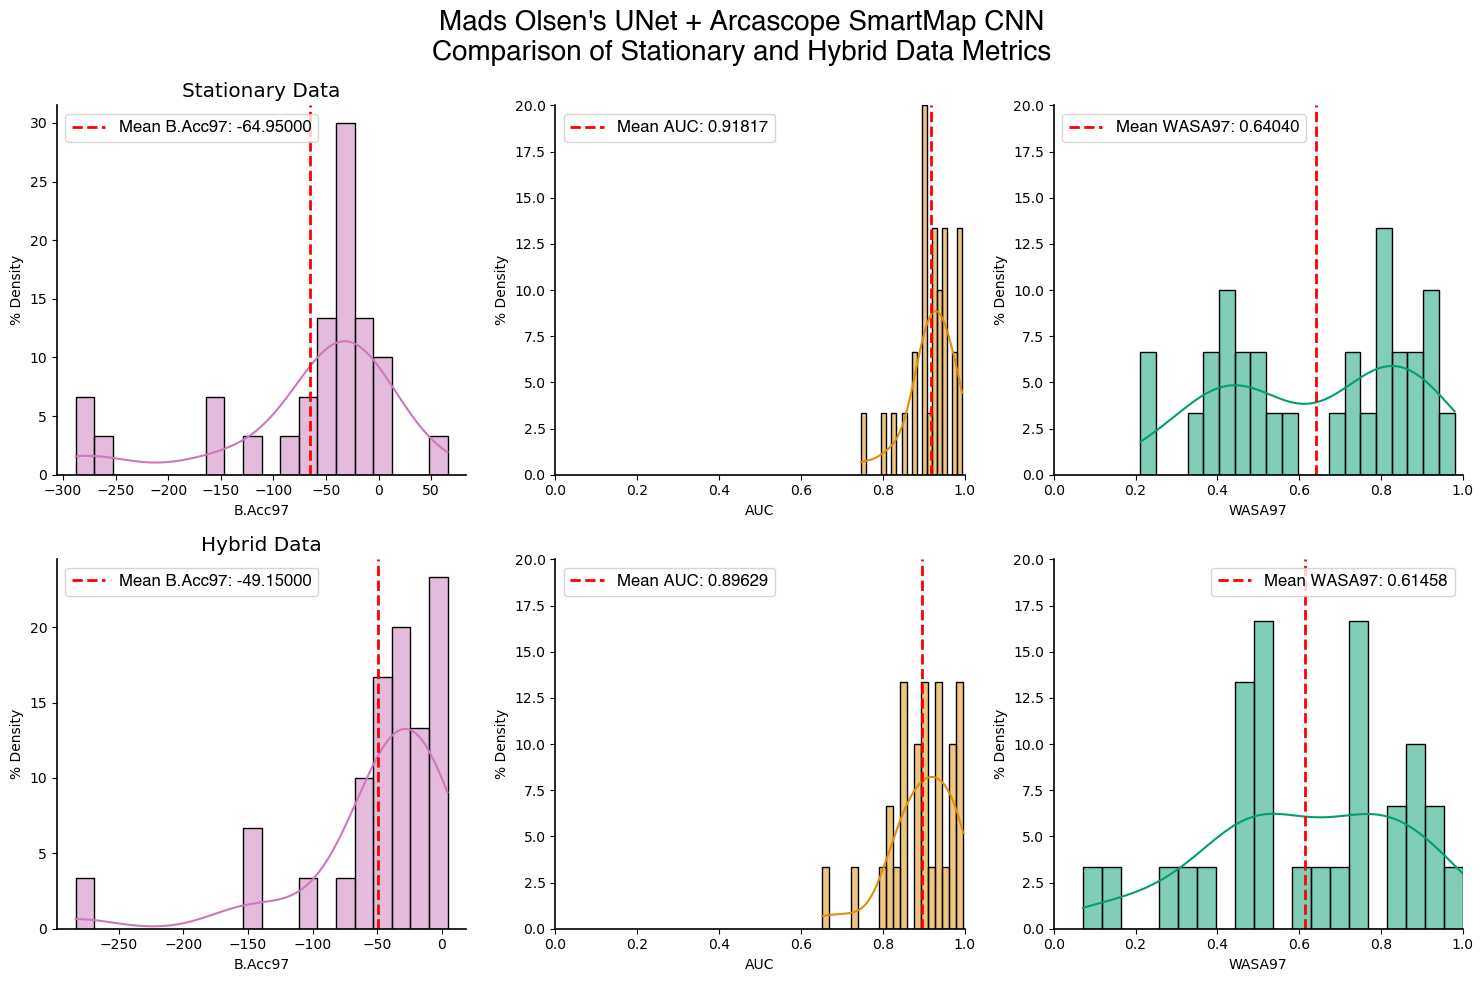

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

cnn_evaluations_df = evaluations_df[evaluations_df['model'] == 'smartmap']
cnn_stationary = cnn_evaluations_df[cnn_evaluations_df['scenario'] == 'stationary']
cnn_hybrid = cnn_evaluations_df[cnn_evaluations_df['scenario'] == 'hybrid']

tri_plot_metrics(evaluations_df=cnn_stationary, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(cnn_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

# for ax in axs.flatten():
#     ax.set_ylim(0, 20)

fig.suptitle("Mads Olsen's UNet + Arcascope SmartMap CNN\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"smartmap_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

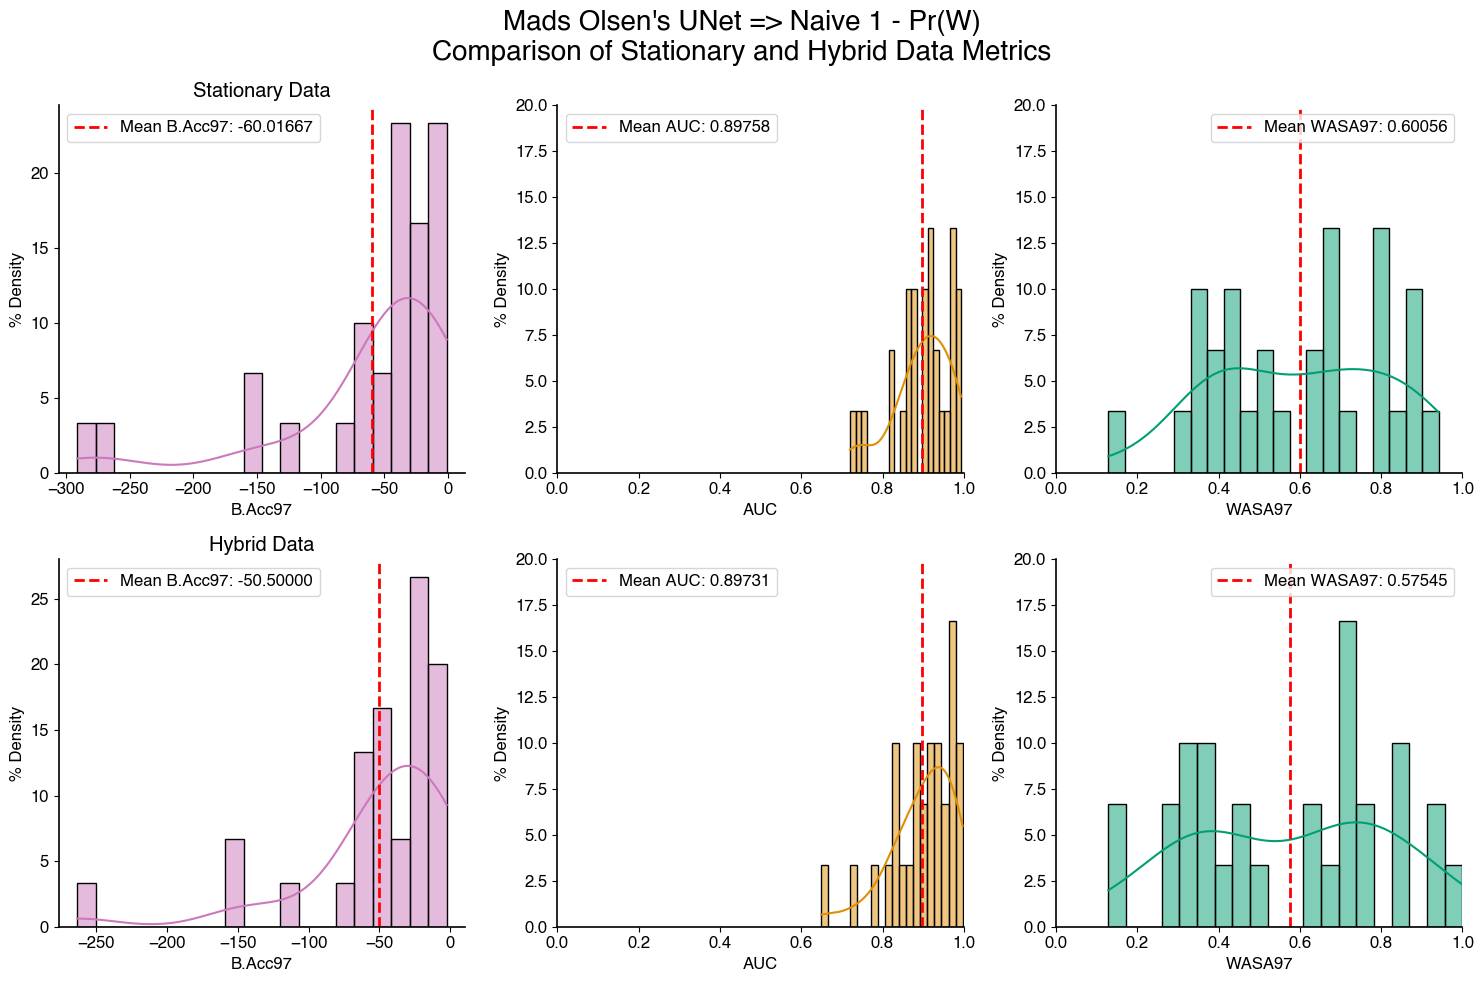

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

naive_evaluations_df = evaluations_df[evaluations_df['model'] == 'naive']
naive_stationary = naive_evaluations_df[naive_evaluations_df['scenario'] == 'stationary']
naive_hybrid = naive_evaluations_df[naive_evaluations_df['scenario'] == 'hybrid']

tri_plot_metrics(naive_stationary, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(naive_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

# for ax in axs.flatten():
#     ax.set_ylim(0, 20)

fig.suptitle("Mads Olsen's UNet => Naive 1 - Pr(W)\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"naive_mo_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

## Tri plot for logistic regression CNN

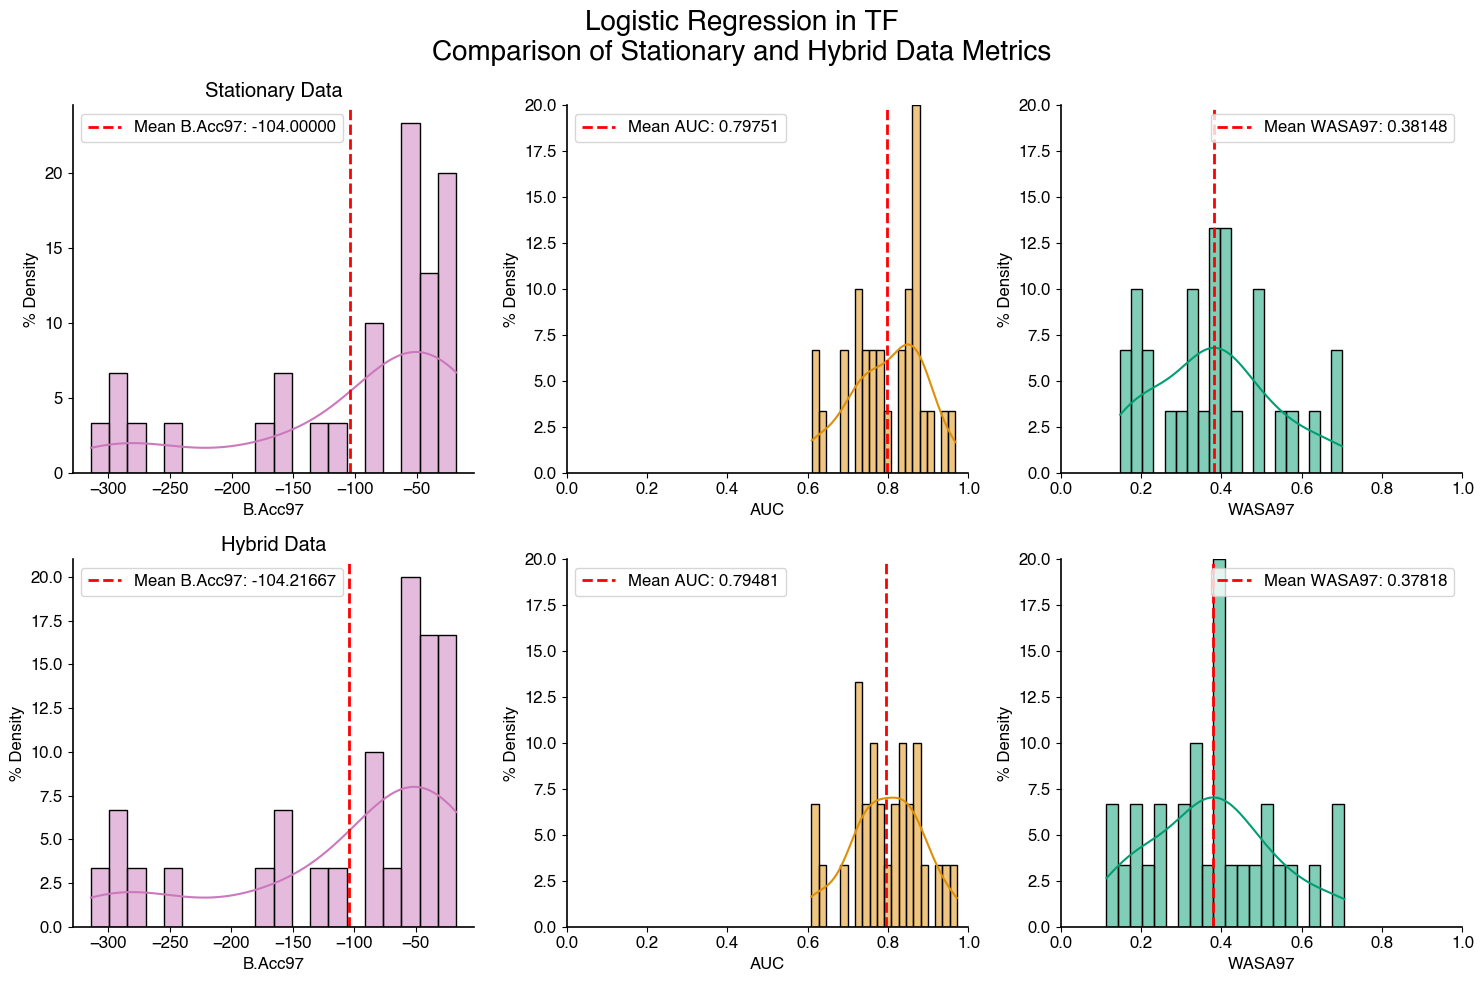

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

lr_evaluations_df = evaluations_df[evaluations_df['model'] == 'lr']
lr_stationary = lr_evaluations_df[lr_evaluations_df['scenario'] == 'stationary']
lr_hybrid = lr_evaluations_df[lr_evaluations_df['scenario'] == 'hybrid']

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

# for ax in axs.flatten():
#     ax.set_ylim(0, 20)

fig.suptitle("Logistic Regression in TF\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"lr_cnn_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')

In [28]:
evaluations_df.to_csv(Path(os.getcwd()).joinpath(f"evaluations_df_{WASA_SLEEP_PERCENT}.csv"), index=False)

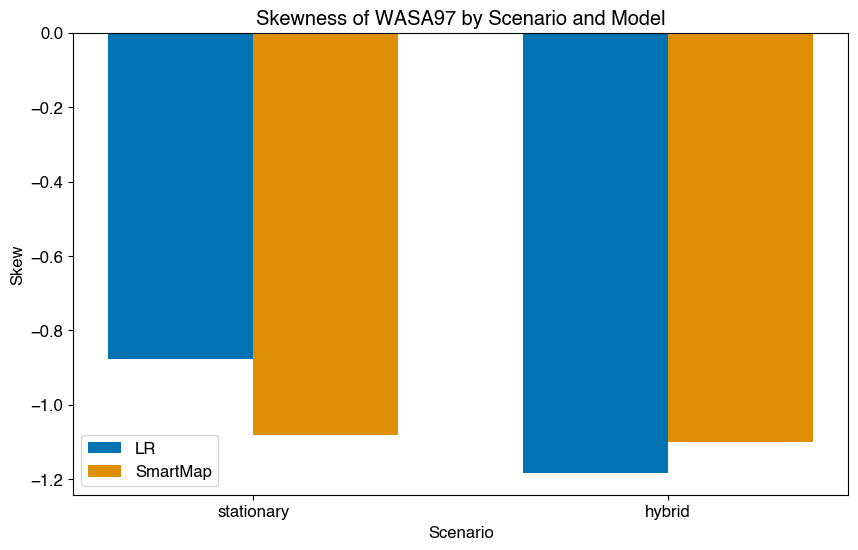

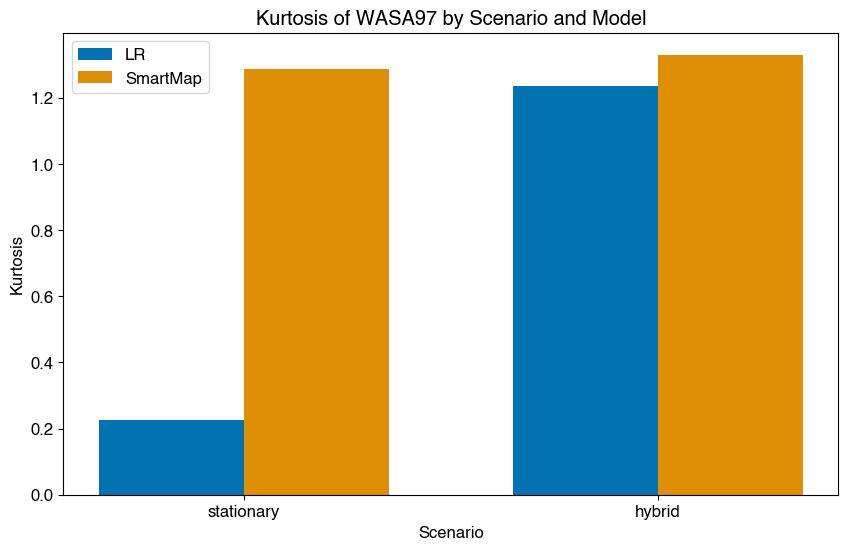

In [29]:
import seaborn as sns
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

smartmap = evaluations_df[evaluations_df['model'] == 'smartmap']
lr = evaluations_df[evaluations_df['model'] == 'lr']
smartmap_wasas = smartmap[WASA_COLUMN]
smartmap_wasas_stationary = smartmap_wasas[smartmap['scenario'] == 'stationary']
smartmap_wasas_hybrid = smartmap_wasas[smartmap['scenario'] == 'hybrid']

lr_wasas = lr[WASA_COLUMN]
lr_wasas_stationary = lr_wasas[lr['scenario'] == 'stationary']
lr_wasas_hybrid = lr_wasas[lr['scenario'] == 'hybrid']

sk_dict = {
    'skew': {m: {} for m in model_types},
    'kurtosis': {m: {} for m in model_types}
}

for scenario in scenarios:
    for model in model_types:
        for stat in ['skew', 'kurtosis']:
            stat_fn = eval(stat)
            sk_dict[stat][model][scenario] = stat_fn(evaluations_df[(evaluations_df['model'] == model) & (evaluations_df['scenario'] == scenario)][WASA_COLUMN])
# Calculate skew and kurtosis for each dataframe
skew_wasa = sk_dict['skew']

kurtosis_wasa = sk_dict['kurtosis']

# Set up data for plotting
# scenarios = list(skew_wasa['lr'].keys())
# models = list(skew_wasa.keys())
skew_values = [[skew_wasa[model][scenario] for scenario in scenarios] for model in model_types]
kurtosis_values = [[kurtosis_wasa[model][scenario] for scenario in scenarios] for model in model_types]

# Define x-axis positions for side-by-side bars
x = np.arange(len(scenarios))
width = 0.35

lr_color = color_palette[0]
smartmap_color = color_palette[1]

# Plot Skewness

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, skew_values[0], width, label='LR', color=lr_color)
plt.bar(x + width/2, skew_values[1], width, label='SmartMap', color=smartmap_color)
plt.xlabel('Scenario')
plt.ylabel('Skew')
plt.title(f'Skewness of WASA{WASA_SLEEP_PERCENT} by Scenario and Model')
plt.xticks(x, scenarios)
plt.legend()
plt.show()

# Plot Kurtosis
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, kurtosis_values[0], width, label='LR', color=lr_color)
plt.bar(x + width/2, kurtosis_values[1], width, label='SmartMap', color=smartmap_color)
plt.xlabel('Scenario')
plt.ylabel('Kurtosis')
plt.title(f'Kurtosis of WASA{WASA_SLEEP_PERCENT} by Scenario and Model')
plt.xticks(x, scenarios)
plt.legend()
plt.show()
